 <center>
    <h1>Foundations of Data Mining</h1>
    <br />
    <hr style="border-color:orange">
    <br /><br /><br />
    Joaquin Vanschoren, Mykola Pechenizkiy, Anne Driemel
</center>

# Course recap

## Remainder of the course:

- Mostly supervised learning: data points are labelled
- Use of R (or Python) in lectures and assignments
    - Mostly R in the lectures
    - Next lecture: tutorials on using ML libraries
- Full code of lecture slides available

## Learning R
- R Studio guide (installation, environments): https://www.rstudio.com/resources/training/online-learning/#R
- DataCamp (beginner to advanced): https://www.datacamp.com
- Codeschool (beginner, step by step): http://tryr.codeschool.com
- Data Carpentry (intermediate): http://www.datacarpentry.org/R-ecology

## Learning Python
- DataCamp (beginner to advanced): https://www.datacamp.com
- CodeCademy (beginner, step by step): https://www.codecademy.com/learn/python
- Google's Python Class (intermediate): https://developers.google.com/edu/python
- Data Carpentry (intermediate): http://www.datacarpentry.org/python-ecology
- Many more...

<center>
    <h1>Foundations of Data Mining</h1>
    <br />
    <hr style="border-color:orange">
    <br />
    <h2>Decision Trees</h2>
    <br /><br /><br />
    Joaquin Vanschoren, Mykola Pechenizkiy, Anne Driemel
</center>

In [2]:
options(warn=-1)
library(mlr) # ML library
library(OpenML) # Data import and sharing results
library(ggplot2) # Plotting
library(cowplot) # Plot styling
library(rattle) # Plotting trees

# Decision trees

- Most widely-used machine learning algorithm
    - Fairly easy to understand and implement
    - Output (model) also easy to understand
    - Easy to use: you don't have to tweak many hyperparameters before it returns something useful
    - Pretty scalable (in number of features and instances)
    - Not top performance, but good place to start
- Depending on the type of the target feature
    - Classification tree (predicts class)
    - Regression tree (predicts numeric value)
- Predictive features can be discrete (categorical) or continuous (numeric), or mixed

## Classification example

In [3]:
iris = getOMLDataSet(did = 61, verbosity=0)$data
iristask = makeClassifTask(data = iris, target = "class")

Loading required package: readr


In [4]:
head(iris)

,sepallength,sepalwidth,petallength,petalwidth,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5,3.6,1.4,0.2,Iris-setosa
5,5.4,3.9,1.7,0.4,Iris-setosa


<img src="files/iris_petal_sepal.png">

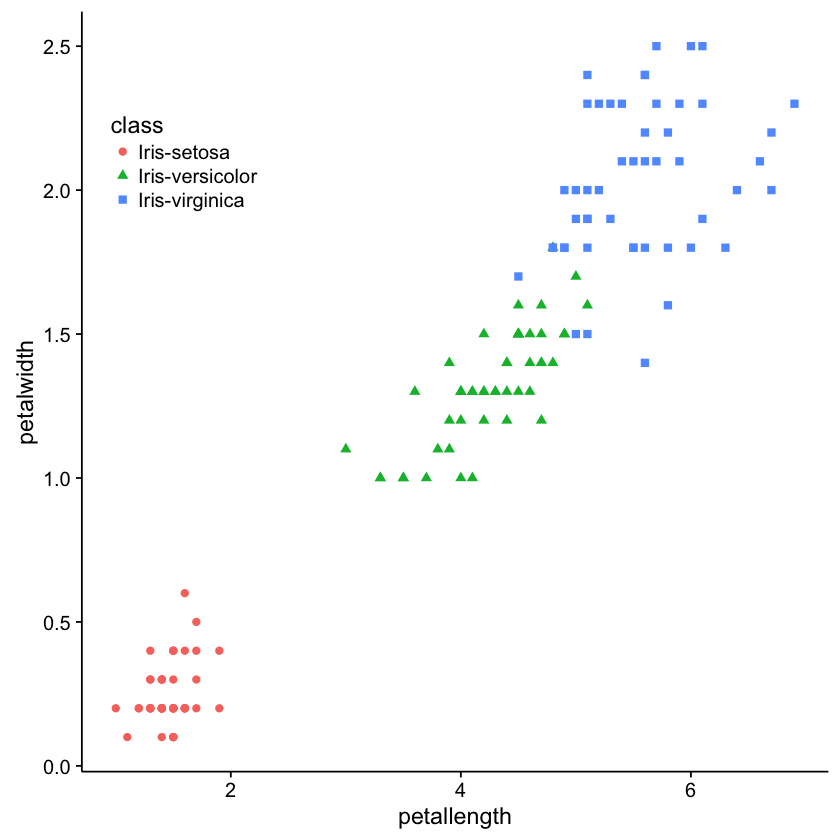

In [5]:
 ggplot(data=iris, aes(x=petallength, y=petalwidth, color=class, shape=class)) + geom_point(size=2) + theme_cowplot() + theme(legend.position = c(0.14, 0.80))

## Learning algorithms (recap)
All learners consist of three main components:

- **Representation**: A model must be represented in a formal language that the computer can handle.
    - Defines the concepts it can learn: the *hypothesis space*
- **Evaluation function**: How to choose one hypothesis over the other?
    - Used internally, can differ from external measure
- **Optimization**: How do we search the hypothesis space?
    - Key to the efficiency of the learner

## Decision trees: Representation
- **Internal nodes**: test value of one particular feature, divide all instances into branches according to the outcome
- **Leaf nodes**: make predictions based on remaining subset

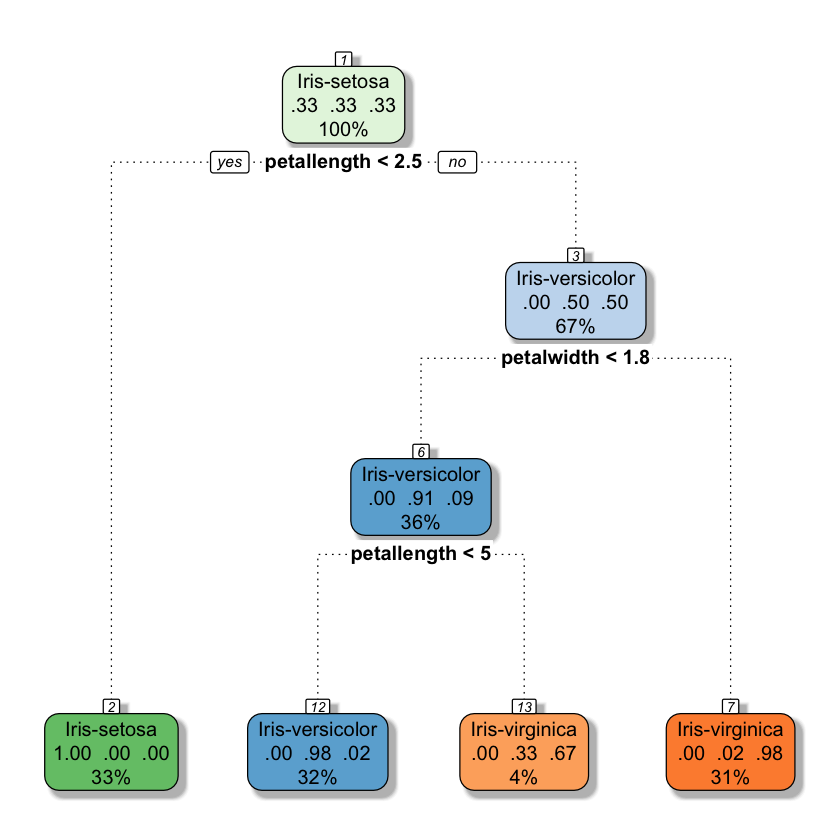

In [6]:
rpart = makeLearner("classif.rpart")
rpart = setHyperPars(rpart, cp = 0, minbucket=4)
model = train(rpart, iristask)
fancyRpartPlot(model$learner.model, sub="")

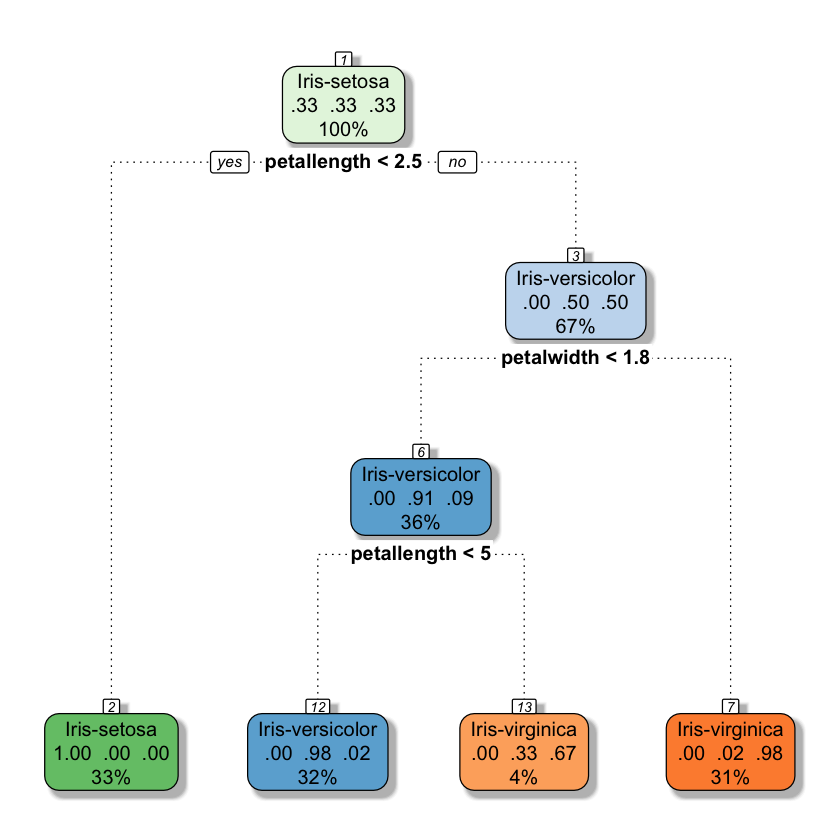

In [7]:
rpart = makeLearner("classif.rpart")
rpart = setHyperPars(rpart, cp = 0, minbucket=4)
model = train(rpart, iristask)
fancyRpartPlot(model$learner.model, sub="")

Trees divide the feature space into (hyper)rectangular regions (leaves) and fit a simple model (or a constant) in each leaf:  

$$ f(x) = \sum_{m=1}^M c_m ~I(x \in R_m) $$

where: $M$ rectangulars $R_m$ are used, and $c_m$ can be:
- the most frequent class
- the fitted class distribution (probabilistic classifier)
- a simple classification model (linear model, naïve Bayes,...)
- a fitted (e.g. average) value (regression)
- a fitted regression model (linear,...)

Variants exist that create non-rectangular regions (e.g. oblique trees)

In [9]:
# Helper function for visualizing the hyperrectangles

library("grid")
library("coin")
Colors <- colorspace::rainbow_hcl(3)
Colors_trans <- apply(rbind(col2rgb(colorspace::rainbow_hcl(3)), alpha = 100, maxColorValue = 255), 2, 
                      function(x) do.call("rgb", as.list(x)))
plot_rectangles <- function(obj, x, y, class, depth) {
  xname <- paste(deparse(substitute(x), 500), collapse = "\n")
  yname <- paste(deparse(substitute(y), 500), collapse = "\n")
  grid.newpage()
  pushViewport(plotViewport(c(5, 4, 2, 2)))
  pushViewport(dataViewport(x,
                            y,
                            name="plotRegion"))
  grid.points(x, y, pch = 19,
              gp=gpar(cex=0.5, col = Colors[class]))
  grid.rect()
  grid.xaxis()
  grid.yaxis()
  grid.text(xname, y=unit(-3, "lines"))
  grid.text(yname, x=unit(-3, "lines"), rot=90)
  seekViewport("plotRegion")
  plot_rect(obj@tree, xname = xname, depth)
  grid.points(x, y, pch = 19,
              gp=gpar(cex=0.5, col = Colors[class]))
}

plot_rect <- function(obj, xname, depth) {
  if (!missing(depth)) {
    if (obj$nodeID >= depth) return()
  }
  if (obj$psplit$variableName == xname) {
    x <- unit(rep(obj$psplit$splitpoint, 2), "native")
    y <- unit(c(0, 1), "npc")
  } else {
    x <- unit(c(0, 1), "npc")
    y <- unit(rep(obj$psplit$splitpoint, 2), "native")
  }
  grid.lines(x, y)
  if (obj$psplit$variableName == xname) {
    pushViewport(viewport(x = unit(current.viewport()$xscale[1], "native"),
                          width = x[1] - unit(current.viewport()$xscale[1], "native"),
                          xscale = c(unit(current.viewport()$xscale[1], "native"), x[1]),
                          yscale = current.viewport()$yscale,
                          just = c("left", "center")))
  } else {
    pushViewport(viewport(y = unit(current.viewport()$yscale[1], "native"),
                          height = y[1] - unit(current.viewport()$yscale[1], "native"),
                          xscale = current.viewport()$xscale,
                          yscale = c(unit(current.viewport()$yscale[1], "native"), y[1]),
                          just = c("center", "bottom")))
  }
  pred <- ifelse(length(obj$left$prediction) == 1, as.integer(obj$left$prediction > 0.5) + 1, which.max(obj$left$prediction))
  grid.rect(gp = gpar(fill = "white"))
  grid.rect(gp = gpar(fill = Colors_trans[pred]))
  if (!is(obj$left, "TerminalNode")) {
    plot_rect(obj$left, xname, depth)
  } 
  popViewport()
  if (obj$psplit$variableName == xname) {
    pushViewport(viewport(x = unit(x[1], "native"),
                          width = unit(current.viewport()$xscale[2], "native")-x[1],
                          xscale = c(x[1], unit(current.viewport()$xscale[2], "native")),
                          yscale = current.viewport()$yscale,
                          just = c("left", "center")))
  } else {
    pushViewport(viewport(y = unit(y[1], "native"),
                          height = unit(current.viewport()$yscale[2], "native")-y[1],
                          xscale = current.viewport()$xscale,
                          yscale = c(y[1], unit(current.viewport()$yscale[2], "native")),
                            just = c("center", "bottom")))
  }
  pred <- ifelse(length(obj$right$prediction) == 1, as.integer(obj$right$prediction > 0.5) + 1, which.max(obj$right$prediction)) 
  grid.rect(gp = gpar(fill = "white"))
  grid.rect(gp = gpar(fill = Colors_trans[pred]))
  if (!is(obj$right, "TerminalNode")) { 
    plot_rect(obj$right, xname, depth)
  } 
  popViewport()
}

### Can you predict the decision boundaries?

In [15]:
library(rpart)
library(party)
tree_iris <- ctree(class ~ ., data = iris)

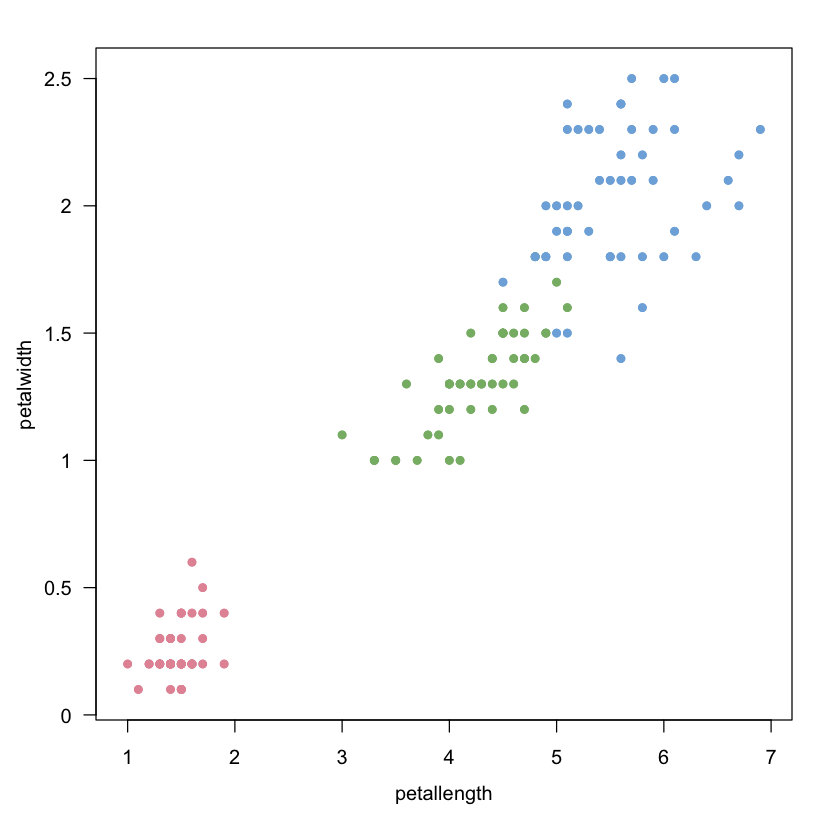

In [16]:
with(iris, plot_rectangles(tree_iris, petallength, petalwidth, class, 0))

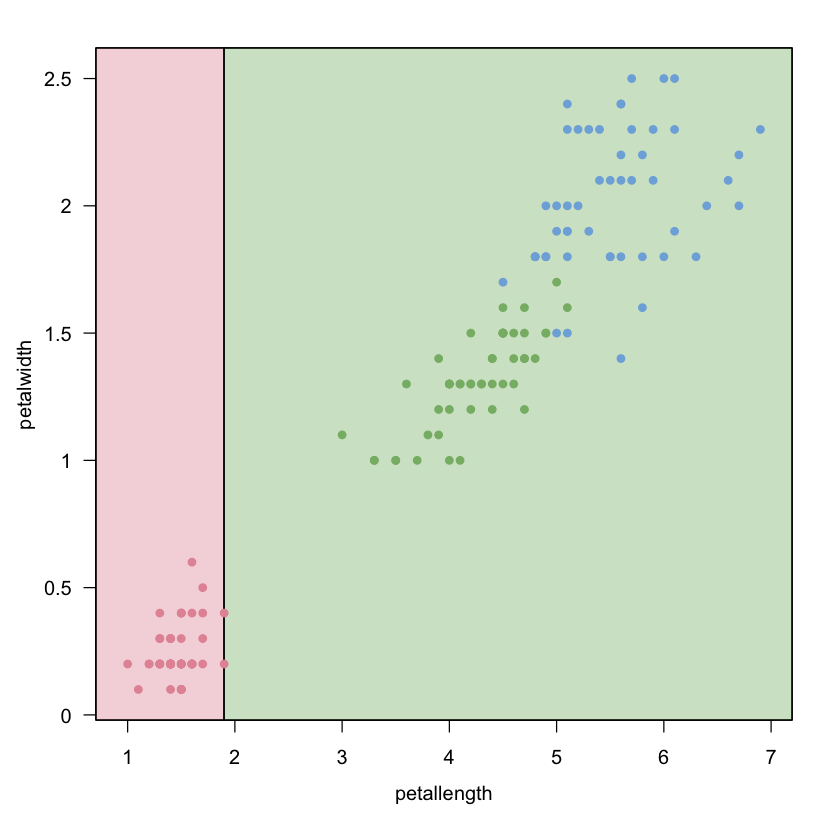

In [17]:
with(iris, plot_rectangles(tree_iris, petallength, petalwidth, class, 2))

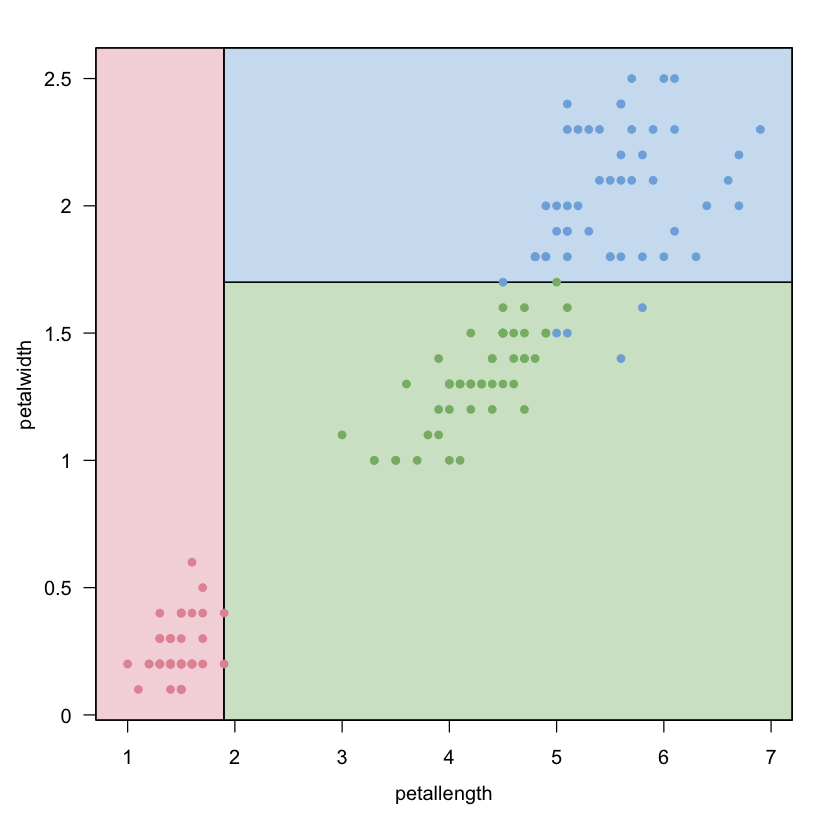

In [18]:
with(iris, plot_rectangles(tree_iris, petallength, petalwidth, class, 4))

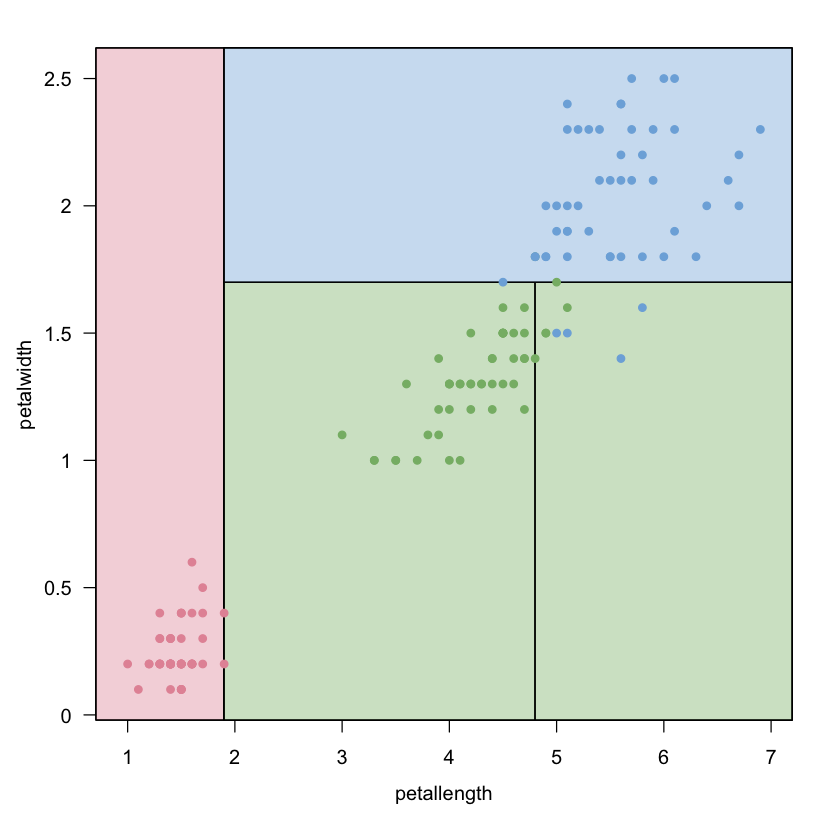

In [19]:
with(iris, plot_rectangles(tree_iris, petallength, petalwidth, class))

## Representation: limitations
- High instability (variance) of the trees: small changes in data can lead to completely different splits
- Prediction function is not smooth (step function is fitted)
- Cannot learn (only approximate) linear dependencies
    - Still works well in many cases (in high dimensions a good splitting can be found)
- Linear dependencies must be modeled over several splits
    - Simple linear correlations translate into complex trees
- Worst case: parity problem (exponential number of leaves)

In [21]:
set.seed(123)
n <- 100
linear <- data.frame(x1 = runif(n),
                   x2 = runif(n))
linear$y <- with(linear, as.integer(x1 > x2))
tree_example <- ctree(y ~ x1 + x2, data = linear)

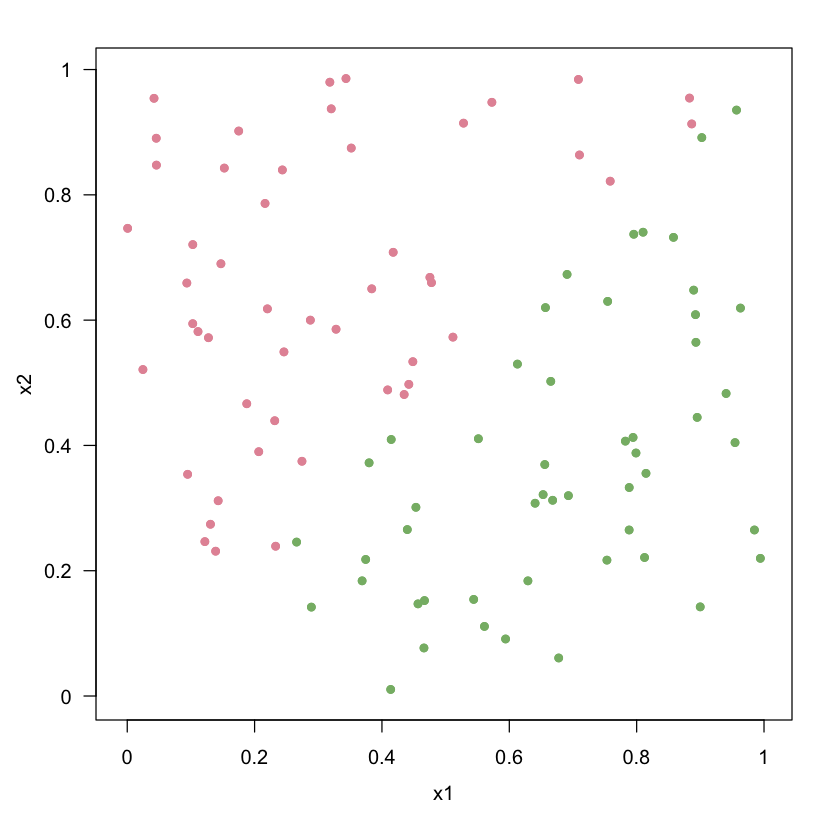

In [22]:
with(linear, plot_rectangles(tree_example, x1, x2, y + 1, 0))

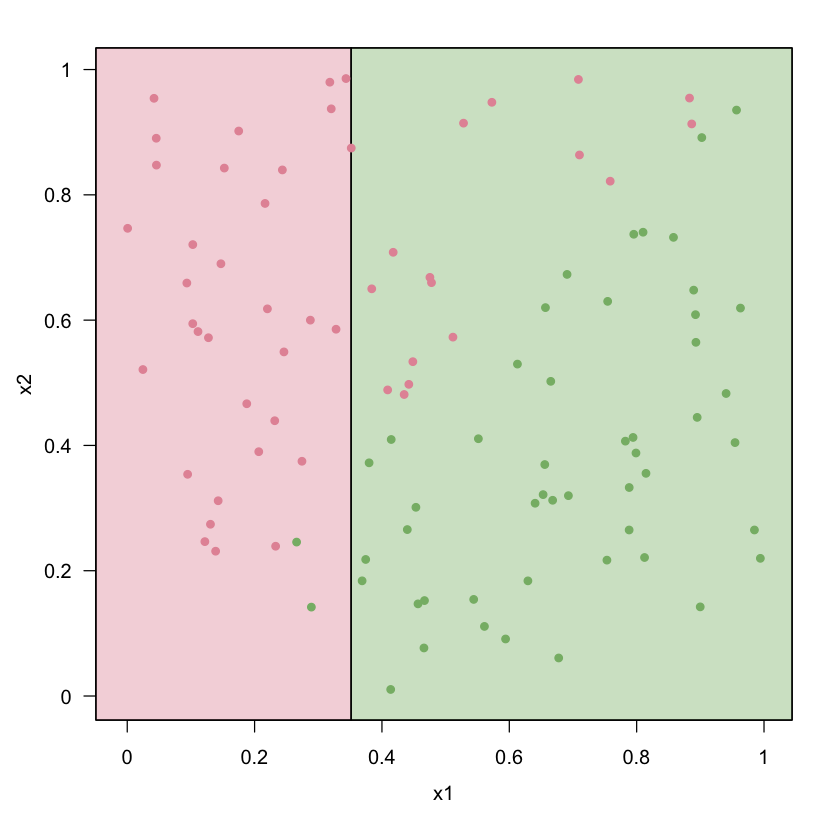

In [23]:
with(linear, plot_rectangles(tree_example, x1, x2, y + 1, 2))

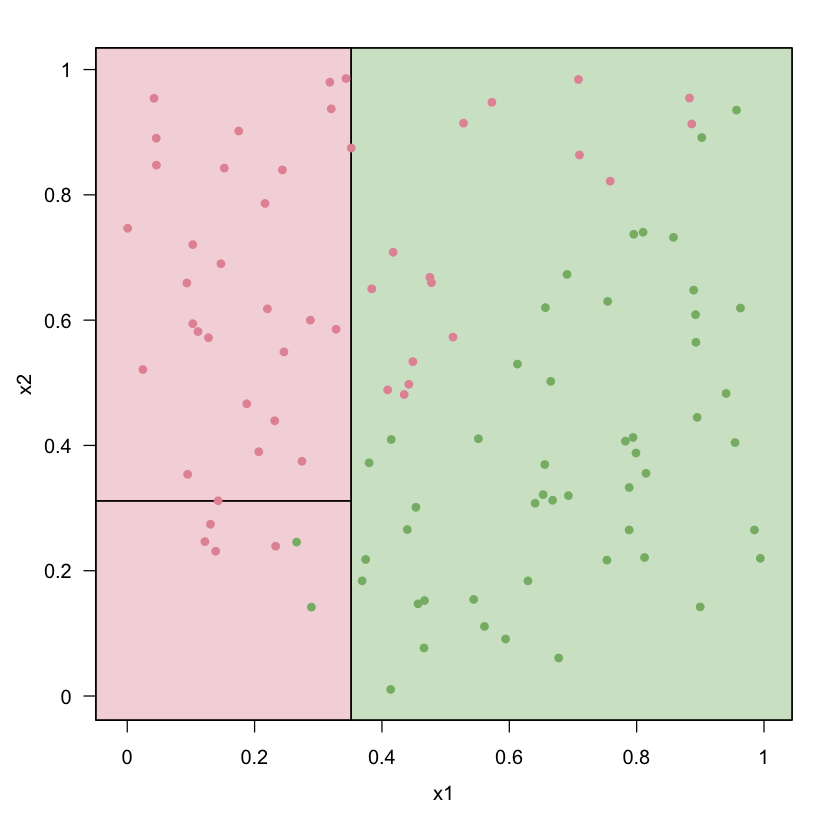

In [24]:
with(linear, plot_rectangles(tree_example, x1, x2, y + 1, 3))

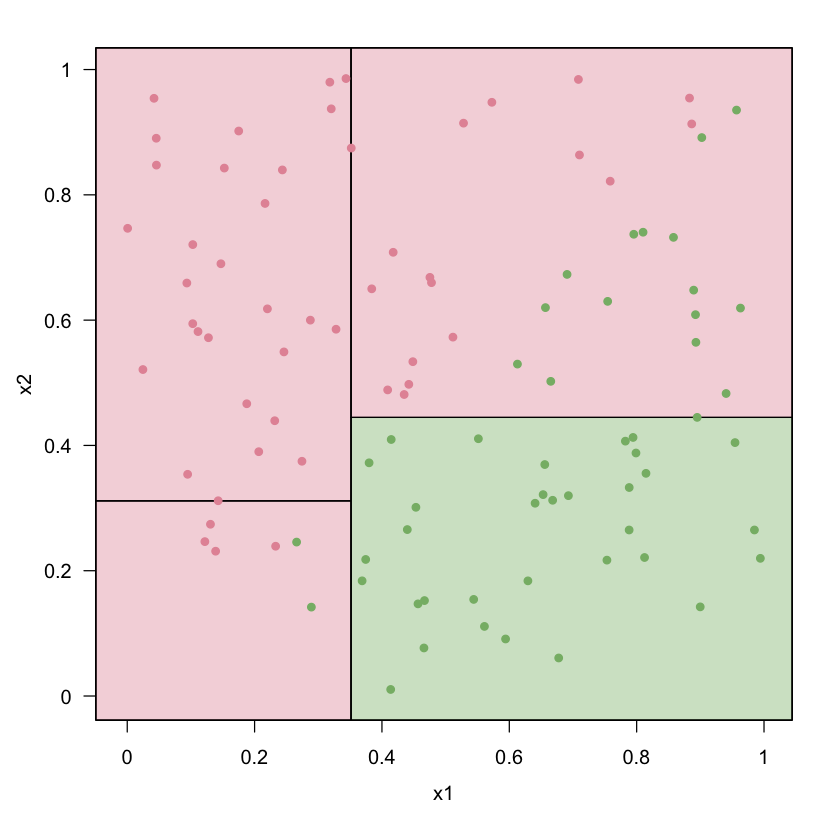

In [25]:
with(linear, plot_rectangles(tree_example, x1, x2, y + 1, 6))

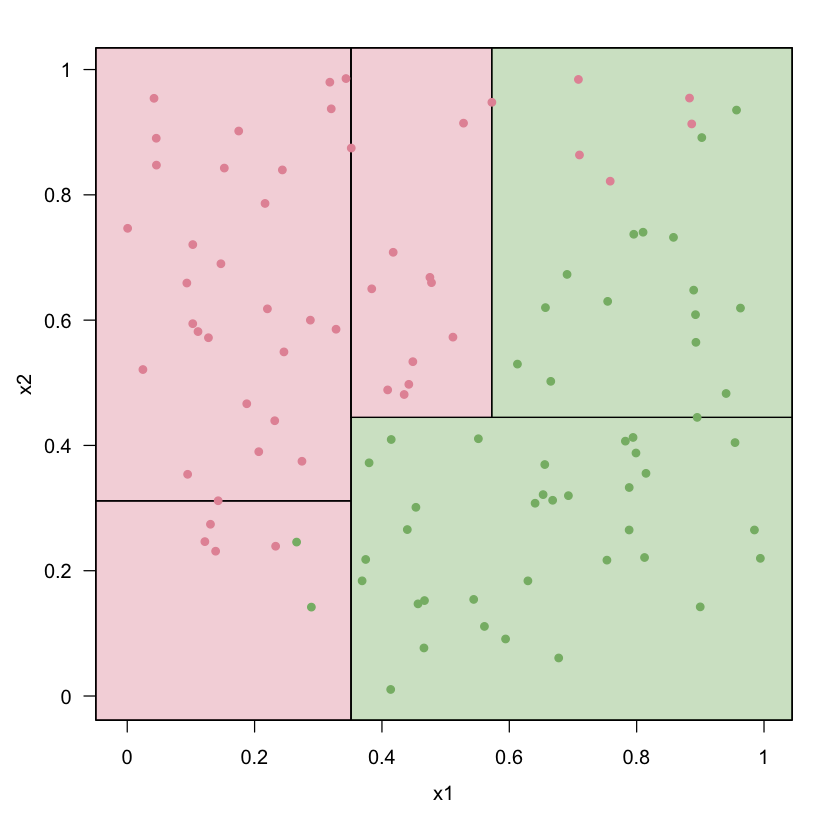

In [26]:
with(linear, plot_rectangles(tree_example, x1, x2, y + 1, 8))

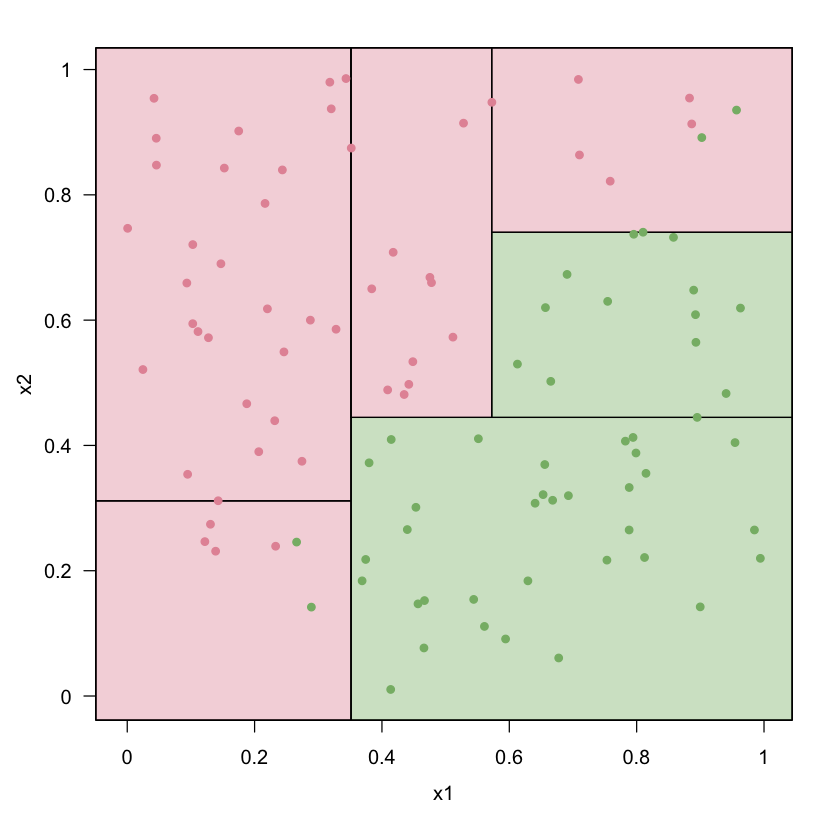

In [27]:
with(linear, plot_rectangles(tree_example, x1, x2, y + 1, 10))

## Evaluation: which split to choose?
For classification ($X_i \rightarrow {class}_{k}$): *Impurity measures*:

- Misclassification Error (leads to larger trees):
$$ 1 - \underset{k}{\operatorname{argmax}} \hat{p}_{k} $$

- Gini-Index (probabilistic predictions):
$$ \sum_{k\neq k'} \hat{p}_k \hat{p}_{k'} = \sum_{k=1}^K \hat{p}_k(1-\hat{p}_k) $$

with $\hat{p}_k$ = the relative frequency of class $k$ in the leaf node

### Information gain

- Entropy (from information theory, smaller trees):
$$ E(X_i) = -\sum_{k=1}^K \hat{p}_k \log_{2}\hat{p}_k $$

- Information Gain (a.k.a. Kullback–Leibler divergence): decrease in entropy after the split
$$ G(X,X_i) = E(X) - \sum_{v=1}^V E(X_{i=v}) $$

with $\hat{p}_k$ = the relative frequency of class $k$ in the leaf node,  
$v$ a specific value for $X_i$

### Entropy example

Ex.| 1 | 2 | 3 | 4 | 5 | 6
---|---|---|---|---|---|---
a1 | T | T | T | F | F | F
a2 | T | T | F | F | T | T
class | + | + | - | + | - | -

$E(X_{class})$ ?  
$G(X, a2)$ ?  
$G(X, a1)$ ?

$E(X_{class})$ = 1 (equal probabilities)  
$G(X, a2)$ = 0 (entropy stays 1)

Ex.| 1 | 2 | 3 | 4 | 5 | 6
---|---|---|---|---|---|---
a1 | T | T | T | F | F | F
a2 | T | T | F | F | T | T
class | + | + | - | + | - | -

$$ E(X_i) = -\sum_{k=1}^K \hat{p}_k \log\hat{p}_k \quad , \quad G(X,X_i) = E(X) - \sum_{v=1}^V E(X_{i=v}) $$

$$E(X_{a1=T}) = - \frac{2}{3} \log_{2}(\frac{2}{3}) - \frac{1}{3} \log_{2}(\frac{1}{3}) = 0.9183 \quad (= E(X_{a1=F}))$$
$$G(X, a1) = E(X_{class}) - \sum_{v=1}^K E(V_{a=v}) = 1 - \frac{1}{2} 0.9183 - \frac{1}{2} 0.9183 = 0.0817 $$

hence we split on a1


### Goodness of fit
For binary splits, best fit = 0

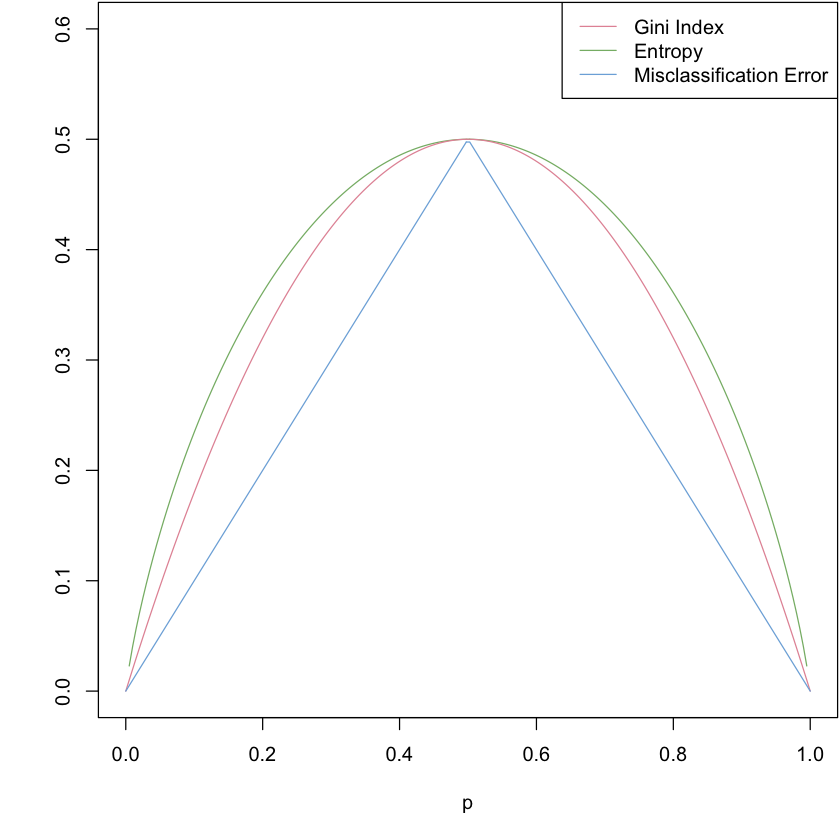

In [33]:
par(mar = c(5.1, 4.1, 0.1, 0.1))
p <- seq(0, 1, length.out = 200)
entropy <- function(p) (p * log(p) + (1-p) * log(1-p))/(2 * log(0.5))
gini <- function(p) 2 * p * (1-p) 
misclassification <- function(p) (1 - max(p, 1-p)) 
plot(p, entropy(p), type = "l", col = Colors[2], ylab = "", ylim = c(0, 0.6))
lines(p, gini(p), col = Colors[1])
lines(p, sapply(p, misclassification), col = Colors[3])
legend("topright", c("Gini Index", "Entropy", "Misclassification Error"),
       col = Colors[1:3], lty = 1)

## Evaluation: which split to choose?
For regression ($X_i \rightarrow Y_i \in {\rm I\!R}$): *Minimal quadratic distance*
    
Dividing the data on split variable $X_j$ at splitpoint $s$ leads to the following half-spaces:

$$ R_1(j, s) = { X : X_j \leq s} \quad and \quad R_2(j, s) = { X : X_j > s} $$
    
The best split variable and the corresponding splitpoint, with predicted value $c_i$ and actual value $Y_i$:

$$ \min_{j,s} \left(\min_{c_1} \sum_{X_{i} \in R_1(j,s)} (Y_i - c_1)^2 + \min_{c_2} \sum_{X_{i} \in R_2(j,s)} (Y_i - c_2)^2 \right) $$

Assuming that the tree predicts $Y_i$ as the average of all $X_i$ in the leaf:
    
$$ \hat{c}_1 = \text{avg}(Y_i | X_{i} \in R_1(j,s)) \quad and \quad \hat{c}_2 = \text{avg}(Y_i | X_{i} \in R_2(j,s)) $$

## Optimization: how to grow the tree?
- Constructive search algorithm (like LEGO's): Start with one piece, add more pieces to build complex structure
- Greedy algorithm: Pick best features and splitpoint, from all features and all possible splitpoints

Options (depends on implementation):
- Binary splits of multi-way splits
- Criteria for the selection of a variable and its splitpoint(s)
- Handling missing value
- Stopping Criteria
- Pruning (trimming leaves)

### Binary or Multi-way splits

- Binary splits (e.g. CART algorithm)
    - No need to mind the penalization of multi-way splits when choosing the split criteria
    - Interpretability of the tree might suffer: multiple splits of the same variable in different levels

### Selection of variable and splitpoints
- Choice of evaluation function (Information gain, Gini-index,...)
- Which splits to consider (for numeric features)?
    - Only split between data points of different classes
    - Split at the point, or halfway between points of different classes

### Handling missing values
Strategies:
- Treat 'missing' as its own (new) catergory
- Missing value imputation (e.g. matrix decomposition)
- When considering feature for a split, ignore data points with missing value
    - To pass examples down the tree (while learning or predicting), find surrogate feature producing similar splits

### Handling many-valued features
What happens when a feature has (almost) as many values as examples?
- Information Gain will select it

One approach: use Gain Ratio instead:
$$ GainRatio(X,X_i) = \frac{Gain(X,X_i)}{SplitInfo(X,X_i)}$$  
$$ SplitInfo(X,X_i) = - \sum_{v=1}^V \frac{|X_{i=v}|}{|X|} log_{2} \frac{|X_{i=v}|}{|X|} $$  

where $X_{i=v}$ is subset of $X_i$ for which $X_i$ has value v.

### Avoiding overfitting
Complexity (and chance of overfitting) increase with size of the tree
- Controlled by *regularization* hyperparameters
    - Stopping criteria
    - Pruning

### Stopping criteria
Choose:
- A minimal number of examples for node before splitting
- A minimal number of examples that must be in each leaf
- A minimal increase in goodness of fit that must be reached before splitting (confidence)
- A maximum depth (number of levels) in the tree

### Pruning
- Pruning optimizes trade-off between goodness of fit and complexity by cutting leaves
- Different strategies. Can you think of one?

#### Reduced error pruning
* Post-pruning, simple and fast
* Split (training) data into training and validation set
* Starting at leaves, prune: replace each node with most popular class
* Greedily remove the one that most improves performance on validation set

#### Cost Complexity Pruning
Cost function $R_{\alpha}$ = training error + complexity term
    $$ R_{\alpha} = R(T) + \alpha \cdot \# \text{leaves} $$

where $R(T)$ represents the error of tree $T$ on the training set

- Generates series of trees
- For every $\alpha$ there is a distinctly defined smallest sub-tree of the original tree, which minimizes the cost function
- $\hat{\alpha}$ can be assessed with cross-validation
- Final tree is fitted on the whole data, where $\hat{\alpha}$ is used to find the optimal size of the tree

## Questions?